In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
d1=pd.read_csv("datasets/2012-1-0-id-78.csv")
d2=pd.read_csv("datasets/2012-2-0-id-78.csv")
d3=pd.read_csv("datasets/2012-3-0-id-78.csv")
d4=pd.read_csv("datasets/2012-4-0-id-78.csv")
d5=pd.read_csv("datasets/2012-5-0-id-78.csv")
d6=pd.read_csv("datasets/2012-6-0-id-78.csv")
d7=pd.read_csv("datasets/2012-7-0-id-78.csv")
d8=pd.read_csv("datasets/2012-8-0-id-78.csv")
d9=pd.read_csv("datasets/2012-9-0-id-78.csv")
d10=pd.read_csv("datasets/2012-10-0-id-78.csv")
d11=pd.read_csv("datasets/2012-11-0-id-78.csv")
d12=pd.read_csv("datasets/2012-12-0-id-78.csv")
combine=[d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12]
result = pd.concat(combine)
result=result.drop("Unnamed: 0",1)
result.head()

,pickup_datetime,pickup_longitude,pickup_latitude,tip_amount,weekday,time,block_id
0,2012-01-09 19:14:00,-73.993335,40.727717,0.00,0,19,9547
1,2012-01-09 20:28:05,-73.985030,40.724199,1.98,0,20,9037
2,2012-01-09 20:56:07,-74.000189,40.737766,1.58,0,20,10157
3,2012-01-09 20:56:12,-74.007974,40.734792,1.65,0,20,9595
4,2012-01-09 20:51:13,-73.989731,40.730629,2.78,0,20,9040


In [3]:
loc=result.loc[result["block_id"]==9052]
loc_lon=loc["pickup_longitude"].mean()
loc_lat=loc["pickup_latitude"].mean()

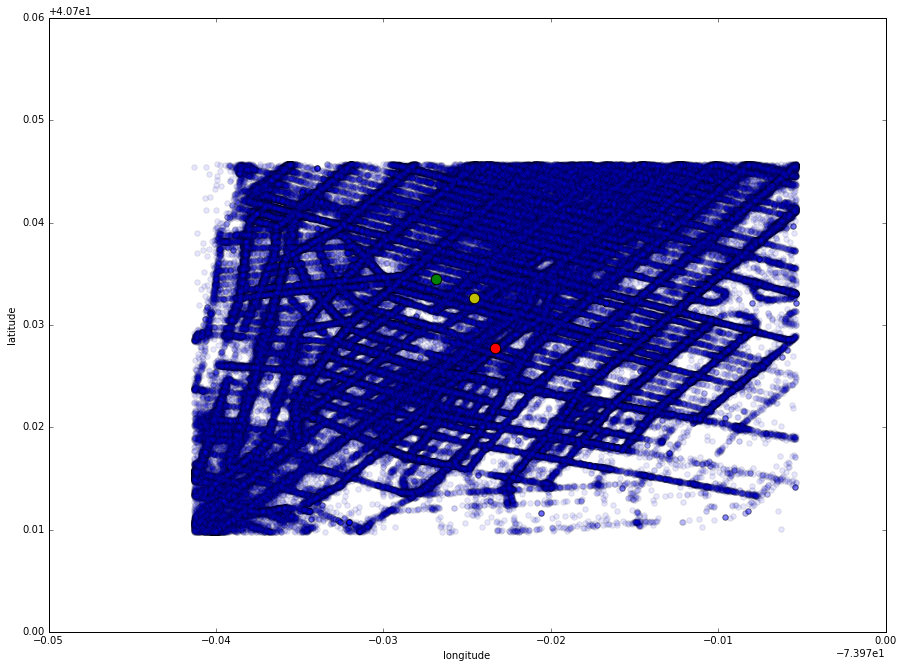

In [4]:
lon=result["pickup_longitude"].values
lat=result["pickup_latitude"].values
plt.figure(figsize=(15,11))
plt.scatter(lon,lat,alpha=0.1,s=30)
original=[[-73.993335,40.727717]]
predicted=[[-73.99683239, 40.73451787]]
plt.scatter(original[0][0],original[0][1],c='r',s=111)
plt.scatter(predicted[0][0],predicted[0][1],c='g',s=111)
plt.scatter(loc_lon,loc_lat,c='y',s=111)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()
# red: current location
# yellow: actual location based on actual data
# green: predicted location using regression

In [5]:
temp=result.groupby("block_id").count()
counted=list(temp["time"].values)
bid=list(temp.index.values)
final=pd.DataFrame(counted,bid)
final.columns = ["pickup_amount"]
final.head()

,pickup_amount
8987,3217
8988,4371
8990,958
8991,3893
8992,2960


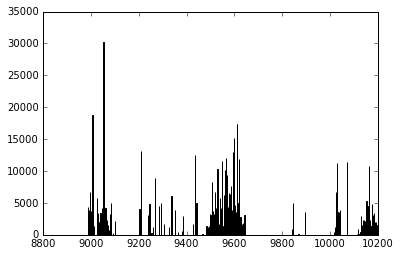

In [6]:
plt.bar(list(final.index.values),final["pickup_amount"])
plt.show()

In [7]:
max_t=0
index=0
mark=0
for e in counted:
    if e>max_t:
        max_t=e
        mark=index
    index+=1
print("block "+str(bid[mark])+": "+str(counted[34])+" total pickups")

block 9052: 30234 total pickups


In [8]:
import matplotlib.path as mplPath

def indexZones(shapeFilename):
    import rtree
    import fiona.crs
    import geopandas as gpd
    index = rtree.Rtree()
    zones = gpd.read_file(shapeFilename).to_crs(fiona.crs.from_epsg(2263))
    for idx,geometry in enumerate(zones.geometry):
        index.insert(idx, geometry.bounds)
    return (index, zones)

def findBlock(p, index, zones):
    match = index.intersection((p.x, p.y, p.x, p.y))
    for idx in match:
        z = mplPath.Path(np.array(zones.geometry[idx].exterior))
        if z.contains_point(np.array(p)):
            return zones['OBJECTID'][idx]
    return -1

def mapToZone(parts):
    import pyproj
    import shapely.geometry as geom
    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)    
    index, zones = indexZones("datasets/block-groups-polygons.geojson")
    i=0
    for line in parts:
        pickup_location  = geom.Point(proj(float(line["pickup_longitude"]), float(line["pickup_latitude"])))
        try:
            print(findBlock(pickup_location, index, zones))
        except AttributeError:
            break
        i+=1

In [10]:
plon=[-73.99683239]
plat=[40.73451787]
to_id=pd.DataFrame({'pickup_longitude':plon, 'pickup_latitude':plat})
mapToZone(to_id.T.to_dict().values())

9239


# Actual street that had the highest pick up amount

In [11]:
original=[[loc_lon,loc_lat]]
from pygeocoder import Geocoder
predicted_location = Geocoder.reverse_geocode(original[0][1], original[0][0])
# predicted_location.street_address might not be applicable
if predicted_location.street_address:
    predicted_address = predicted_location.street_address
else:
    predicted_address = '%s %s, %s' %(predicted_location.street_number, predicted_location.route, predicted_location.city)
print (predicted_address)

17 East 9th Street, New York
